In [3]:
'''Import packages'''
'''Requires numpy, pandas, scikit-learn, and matplotlib/seaborn'''
import numpy as np
import pandas as pd
from skbio.stats import composition
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Lasso
from scipy.stats import spearmanr

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

'''Import script which contains functions'''
import analysis_functions
from analysis_functions import get_r2
from analysis_functions import get_lassoCV
from analysis_functions import perform_randomizedLasso

from IPython.display import display, HTML

#If we want to time the implementation: 
#import time
#start_time = time.time()

Import the dataframes: 

In [4]:
'''Import data'''
data_abs = pd.read_csv('data/Chloroplasts_removed/Nov2017_Filtering/5seqs_in_10percent_samples/nochloro_absolute_otu_5in10percent.tsv', sep=' ', index_col=None, header=0, float_precision='high')
data_rel = pd.read_csv('data/Chloroplasts_removed/Nov2017_Filtering/5seqs_in_10percent_samples/nochloro_relative_5in10percent.tsv', sep=' ', index_col=None, header=0, float_precision='high')
target = pd.read_csv('data/Chloroplasts_removed/Nov2017_Filtering/5seqs_in_10percent_samples/nochloro_HNA_LNA_5in10percent.tsv', sep= ' ', index_col=0, header=0)

**2)**: At 01-05-'17 @marschmi found that a few samples can be seen as outliers, as they represent the bottom waters of productive inland lakes, resulting in a big difference of the HNA percentage. These samples are the following: Z14055F, Z14003F, Z14007F, Z14023F, Z14011F. A code of line is added, in order to be able to run the pipeline without these samples; 

In [5]:
#samples_to_drop = ['Z14055F', 'Z14003F', 'Z14007F', 'Z14023F', 'Z14011F']
#index = target.index.drop(samples_to_drop)

In [6]:
'''Set sample names as index and shuffle data'''
index = data_rel.index

#Remove outlier samples:
data_abs = data_abs.loc[index,:] 
data_rel = data_rel.loc[index,:]
target = target.loc[index,:]
#productivity = productivity.loc[index,:]

#Shuffle data: 
data_abs = data_abs.sample(frac=1, random_state=3)
data_rel = data_rel.sample(frac=1, random_state=3)
target = target.sample(frac=1, random_state=3)
#productivity = productivity.sample(frac=1, random_state=3) 

#Create target columns of HNA-values: 
hna = target.loc[:,'HNA.cells']
hna_rel = hna/target.loc[:,'Total.cells']
hna = pd.Series(hna, index=hna.index)
hna_rel = pd.Series(hna_rel, index=hna.index)

#Create target columns of LNA-values: 
lna = target.loc[:,'LNA.cells']
lna_rel = lna/target.loc[:,'Total.cells']
lna = pd.Series(lna, index=lna.index)
lna_rel = pd.Series(lna_rel, index=lna.index)

In [7]:
#Some variables to store information and to create inner and outer CV-folds

data_rel = data_rel.loc[:, (data_rel != 0).any(axis=0)]
otus = list(data_rel.columns)

#cv_out = 10
cv = 5
#outer_cv = KFold(n_splits=cv_out, shuffle=False)

#otu_scores_cv = pd.DataFrame(columns=otus)
#r2_cv = np.zeros(cv_out)
#thresholds_cv = np.zeros(cv_out)

#pred = pd.Series(index=data_abs.index)
#final_scores = pd.DataFrame(columns=otus)

#thresholds = np.arange(0,1,0.01)
#t = 0

In [8]:
''' Log-Ratio analyses '''
min_bact = data_rel.loc[:,otus].min()[data_rel.loc[:,otus].min() > 0]
min_bact = min_bact.min()
data_rel.replace(0,min_bact,inplace=True)
data_rel_clr = pd.DataFrame(composition.clr(data_rel.loc[:,otus]), columns=otus)

''' Standardize data '''
from analysis_functions import standardize_df
data_stand, scaler = standardize_df(data_rel_clr,otus)

To do so, we use the **_Randomized Lasso_**: this method makes use of two kinds of randomization in order to select variables (i.e., OTU's) with a certain _stability_: (1) it fits a Lasso to various bootstrap subsamples and (2) it perturbs the initial weighting of certain variables. 

This results in a $score \in [0,1]$ that is assigned to variables, with 0 denoting the case where a variable is never chosen by the Lasso, and 1 denoting the case where a variable always is chosen. In other words, the higher the score, the more important a variable can be considered to be. 

**First goal: ** try to pinpoint those OTU's for which we are sure they are present in the '_HNA-cloud_'. 

**Univariate Feature Selection**: 

Let's compare two methods: 
- f_regression (f-score pearson correlation), 
- Mutual information,  
- (other methods can follow as well). 

In [9]:
f_regr, f_regr_p = f_regression(data_stand.loc[:,otus],hna)
r_spearman = np.zeros(len(otus))
p_spearman = np.zeros(len(otus))
for i in np.arange(0,len(otus)):
    r_spearman[i], p_spearman[i] = spearmanr(data_stand.loc[:,otus[i]],hna, axis=0)
uni_fs = pd.DataFrame(f_regr, index=otus, columns = ['f_regr'])
uni_fs['p-value'] = f_regr_p
uni_fs['r_spearman'] = r_spearman
uni_fs['p_spearman'] = p_spearman
#uni_fs['mi'] = mutual_info_regression(data_stand.loc[:,otus],hna)
#uni_fs.sort_values(ascending=False,inplace=True, by='f_regr')
display(uni_fs.head(10))

,f_regr,p-value,r_spearman,p_spearman
Otu000001,83.568198,2.118737e-16,-0.644679,4.116843e-21
Otu000004,2.082810,1.508501e-01,-0.162051,3.584920e-02
Otu000005,7.163077,8.188307e-03,0.240311,1.703165e-03
Otu000006,7.125032,8.356412e-03,-0.248893,1.140795e-03
Otu000007,5.502316,2.017307e-02,-0.216490,4.823545e-03
Otu000009,0.000448,9.831449e-01,-0.004781,9.509578e-01
Otu000010,2.482695,1.170087e-01,0.141741,6.684400e-02
Otu000011,0.043421,8.351898e-01,-0.027113,7.271892e-01
Otu000012,0.633057,4.273725e-01,-0.057957,4.555317e-01
Otu000016,3.506936,6.287082e-02,-0.095479,2.182746e-01


In [10]:
#uni_fs.to_csv('F_test_spearman_hna_1seq3.csv')

Select otu's based on $p < \text{thr}$: 

In [11]:
uni_fs_selected_f = uni_fs[uni_fs.loc[:,'p-value'].values < 0.05]
print('Number of selected OTUs using F-test with p < 0.05: ' + str(len(uni_fs_selected_f)))
uni_fs_selected_f = uni_fs[uni_fs.loc[:,'p-value'].values < 0.01]
print('Number of selected OTUs using F-test with p < 0.01: ' + str(len(uni_fs_selected_f)))
uni_fs_selected_f = uni_fs[uni_fs.loc[:,'p_spearman'].values < 0.05]
print('Number of selected OTUs using spearman correlation with p < 0.05: ' + str(len(uni_fs_selected_f)))
uni_fs_selected_f = uni_fs[uni_fs.loc[:,'p_spearman'].values < 0.01]
print('Number of selected OTUs using spearman correlation with p < 0.01: ' + str(len(uni_fs_selected_f)))

Number of selected OTUs using F-test with p < 0.05: 232
Number of selected OTUs using F-test with p < 0.01: 178
Number of selected OTUs using spearman correlation with p < 0.05: 395
Number of selected OTUs using spearman correlation with p < 0.01: 359


What happens when we tune a threshold in function of the f_score: 

In [12]:
from analysis_functions import get_r2_scores
#thr_otu_f_regr_hna, r2_otu_f_regr_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, uni_fs['f_regr'], cv)
#thr_otu_f_regr_lna, r2_otu_f_regr_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, uni_fs['f_regr'], cv)

In [13]:
#plt.figure()
#sns.regplot(x=thr_otu_f_regr_hna,y=r2_otu_f_regr_hna, fit_reg=False, label='HNA')
#sns.regplot(x=thr_otu_f_regr_lna,y=r2_otu_f_regr_lna, fit_reg=False, label='LNA')
#plt.xlabel('F-score', size=22)
#plt.xticks(size=10)
#plt.ylabel(r'$R^2$', size=22)
#plt.yticks(size=10)
#plt.title('F-test', size=24)
#plt.legend()
#plt.show()

In [14]:
thr_otu_sp_hna, r2_otu_sp_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, np.absolute(uni_fs['r_spearman']), cv)
thr_otu_sp_lna, r2_otu_sp_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, np.absolute(uni_fs['r_spearman']), cv)

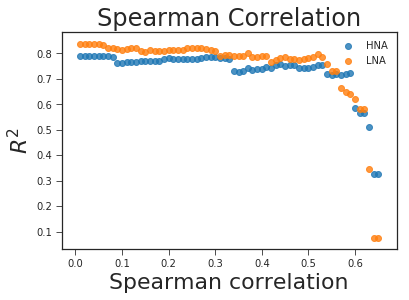

In [15]:
plt.figure()
sns.regplot(x=thr_otu_sp_hna,y=r2_otu_sp_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_sp_lna,y=r2_otu_sp_lna, fit_reg=False, label='LNA')
plt.xlabel('Spearman correlation', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.title('Spearman Correlation', size=24)
plt.legend()
plt.show()

In [16]:
#uni_fs.sort_values(ascending=False,inplace=True, by='mi')
#display(uni_fs.head(10))
#thr_otu_mi_hna, r2_otu_mi_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, uni_fs['mi'], cv)
#thr_otu_mi_lna, r2_otu_mi_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, uni_fs['mi'], cv)

In [17]:
#plt.figure()
#sns.regplot(x=thr_otu_mi_hna,y=r2_otu_mi_hna, fit_reg=False, label='HNA')
#sns.regplot(x=thr_otu_mi_lna,y=r2_otu_mi_lna, fit_reg=False, label='LNA')
#plt.xlabel('MI', size=22)
#plt.xticks(size=10)
#plt.ylabel(r'$R^2$', size=22)
#plt.yticks(size=10)
#plt.title('Mutual Information', size=24)
#plt.legend()
#plt.show()

In [18]:
from analysis_functions import get_lassoCV_alpha

alpha = get_lassoCV_alpha(data_stand.loc[:,otus],hna,otus,cv)
    
otu_scores = pd.DataFrame(perform_randomizedLasso(data_stand.loc[:,otus], hna, alpha), index=otus, columns=['score'])
otu_scores.sort_values(ascending=False,inplace=True, by='score')

thr_otu_scores_hna, r2_otu_scores_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, otu_scores, cv)
thr_otu_scores_lna, r2_otu_scores_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, otu_scores, cv)

/home/prubbens/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


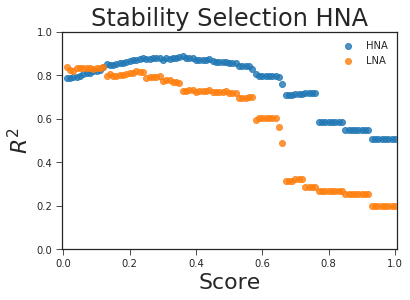

In [19]:
plt.figure()
sns.regplot(x=thr_otu_scores_hna,y=r2_otu_scores_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_scores_lna,y=r2_otu_scores_lna, fit_reg=False, label='LNA')
plt.axis([-0.005,1.005,0,1])
plt.xlabel('Score', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.legend()
plt.title('Stability Selection HNA', size=24)
plt.show()

In [20]:
r2_final = r2_otu_scores_hna.max()
thr = thr_otu_scores_hna[r2_otu_scores_hna.argmax()]
print('R²_cv(hna): ' + str(r2_final) )
print('Threshold score: ' + str(thr))

R²_cv(hna): 0.887963007009
Threshold score: 0.36


In [21]:
otu_scores = otu_scores.assign(abun_abs_mean = data_abs.loc[:,otus].mean())
otu_scores = otu_scores.assign(abun_abs_CV = data_abs.loc[:,otus].std()/data_abs.loc[:,otus].mean())
otu_scores =  otu_scores.assign(abun_rel_mean = data_rel.loc[:,otus].mean())
otu_scores = otu_scores.assign(abun_rel_CV = data_rel.loc[:,otus].std()/data_rel.loc[:,otus].mean())
otu_scores['r_spearman'] = uni_fs.loc[otu_scores.index,'r_spearman']
otu_scores['p_spearman'] = uni_fs.loc[otu_scores.index,'p_spearman']
otu_scores.to_csv('Final/hnascores_otus_5seq10_aitch.csv')

In [22]:
otu_scores_selected = otu_scores[otu_scores.score.values>thr]
selected_otus = otu_scores_selected.index
otu_scores_selected.to_csv('Final/hnascores_otus_tuned_thr_'+str(thr)+'_5seq10_aitch.csv')
display(otu_scores_selected.head(10))
print('Size list selected OTUs: ' + str(len(selected_otus)))

,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV,r_spearman,p_spearman
Otu000173,1.000000,9202.636543,1.868851,0.001394,1.547572,0.587277,5.908331e-17
Otu000682,0.913333,1400.166800,4.290562,0.000352,1.614426,-0.325669,1.649878e-05
Otu000242,0.833333,5151.362021,3.267847,0.000847,2.129433,0.070016,3.671379e-01
Otu000001,0.756667,388884.795943,0.710040,0.099741,0.624193,-0.644679,4.116843e-21
Otu000216,0.716667,8549.311586,3.381402,0.001856,2.870124,-0.072674,3.491880e-01
Otu000535,0.690000,539.500927,3.198874,0.000279,0.838590,-0.377931,4.405039e-07
Otu000088,0.660000,4796.152365,1.417696,0.001929,1.599274,-0.529482,1.592162e-13
Otu000060,0.643333,27431.752891,1.430959,0.004103,1.018680,0.628330,7.706592e-20
Otu000154,0.640000,4420.233668,1.423808,0.001585,2.344583,-0.290771,1.314991e-04
Otu000778,0.573333,1003.428651,3.139226,0.000296,0.830592,-0.161596,3.637995e-02


Size list selected OTUs: 35


In [23]:
print('R²_cv of HNA-selected OTUs in function of LNA: ' + str(r2_otu_scores_lna[r2_otu_scores_hna.argmax()]) )

R²_cv of HNA-selected OTUs in function of LNA: 0.728711490507


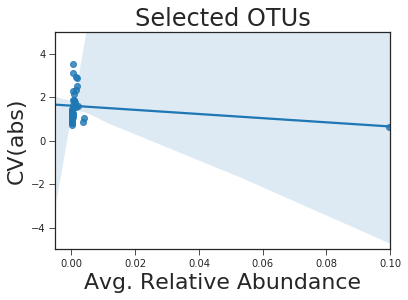

In [24]:
plt.figure()
sns.regplot(x='abun_rel_mean',y='abun_rel_CV', data=otu_scores_selected)
plt.axis([-0.005,0.1,-5,5])
plt.xlabel('Avg. Relative Abundance', size=22)
plt.xticks(size=10)
plt.ylabel('CV(abs)', size=22)
plt.yticks(size=10)
plt.title('Selected OTUs', size=24)
plt.show()

In [25]:
#optimal_scores.to_csv('HNA_selectedOTUs_stand_abun_remov' + str(abun)+'_R2'+str(r2_final)+'.csv')

**Second goal**: Can we use the same pipeline to predict the _LNA_-counts? 

In [26]:
f_regr_lna, f_regr_p_lna = f_regression(data_stand.loc[:,otus],lna)
uni_fs_lna = pd.DataFrame(f_regr_lna, index=otus, columns = ['f_regr'])
uni_fs_lna['p-value'] = f_regr_p_lna
r_spearman = np.zeros(len(otus))
p_spearman = np.zeros(len(otus))
for i in np.arange(0,len(otus)):
    r_spearman[i], p_spearman[i] = spearmanr(data_stand.loc[:,otus[i]],lna, axis=0)
uni_fs_lna = pd.DataFrame(f_regr_lna, index=otus, columns = ['f_regr'])
uni_fs_lna['p-value'] = f_regr_p
uni_fs_lna['r_spearman'] = r_spearman
uni_fs_lna['p_spearman'] = p_spearman
#uni_fs_lna['mi'] = mutual_info_regression(data_stand.loc[:,otus],lna)
#uni_fs_lna.sort_values(ascending=False,inplace=True, by='f_regr')
display(uni_fs_lna.head(10))

,f_regr,p-value,r_spearman,p_spearman
Otu000001,16.484189,2.118737e-16,-0.440920,2.209084e-09
Otu000004,5.022287,1.508501e-01,-0.159766,3.857911e-02
Otu000005,49.750010,8.188307e-03,0.480133,4.525430e-11
Otu000006,4.829647,8.356412e-03,-0.203471,8.161098e-03
Otu000007,4.467086,2.017307e-02,-0.177026,2.170143e-02
Otu000009,2.378683,9.831449e-01,-0.112003,1.483334e-01
Otu000010,16.405873,1.170087e-01,0.283958,1.913925e-04
Otu000011,1.875008,8.351898e-01,-0.097261,2.097651e-01
Otu000012,0.661655,4.273725e-01,0.031342,6.867219e-01
Otu000016,4.908466,6.287082e-02,0.113664,1.423738e-01


In [27]:
uni_fs_selected_f_lna = uni_fs_lna[uni_fs_lna.loc[:,'p-value'].values < 0.05]
print('Number of selected OTUs with p < 0.05: ' + str(len(uni_fs_selected_f_lna)))
uni_fs_selected_f_lna = uni_fs_lna[uni_fs_lna.loc[:,'p-value'].values < 0.01]
print('Number of selected OTUs with p < 0.01: ' + str(len(uni_fs_selected_f_lna)))
uni_fs_selected_f = uni_fs_lna[uni_fs_lna.loc[:,'p_spearman'].values < 0.05]
print('Number of selected OTUs using spearman correlation with p < 0.05: ' + str(len(uni_fs_selected_f)))
uni_fs_selected_f = uni_fs_lna[uni_fs_lna.loc[:,'p_spearman'].values < 0.01]
print('Number of selected OTUs using spearman correlation with p < 0.01: ' + str(len(uni_fs_selected_f)))

Number of selected OTUs with p < 0.05: 232
Number of selected OTUs with p < 0.01: 178
Number of selected OTUs using spearman correlation with p < 0.05: 394
Number of selected OTUs using spearman correlation with p < 0.01: 368


In [28]:
#uni_fs.to_csv('F_test_spearman_lna_1seq3.csv')

In [29]:
#thr_otu_f_regr_lna, r2_otu_f_regr_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, uni_fs_lna['f_regr'], cv)
#thr_otu_f_regr_hna, r2_otu_f_regr_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, uni_fs_lna['f_regr'], cv)

In [30]:
#plt.figure()
#sns.regplot(x=thr_otu_f_regr_hna,y=r2_otu_f_regr_hna, fit_reg=False, label='HNA')
#sns.regplot(x=thr_otu_f_regr_lna,y=r2_otu_f_regr_lna, fit_reg=False, label='LNA')
#plt.axis([-0.005,1.005,0,1])
#plt.xlabel('F-score', size=22)
#plt.xticks(size=10)
#plt.ylabel(r'$R^2$', size=22)
#plt.yticks(size=10)
#plt.title('F-test', size=24)
#plt.legend()
#plt.show()

In [31]:
thr_otu_sp_lna, r2_otu_sp_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, np.absolute(uni_fs_lna['r_spearman']), cv)
thr_otu_sp_hna, r2_otu_sp_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, np.absolute(uni_fs_lna['r_spearman']), cv)

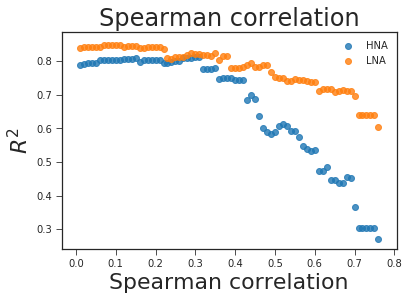

In [32]:
plt.figure()
sns.regplot(x=thr_otu_sp_hna,y=r2_otu_sp_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_sp_lna,y=r2_otu_sp_lna, fit_reg=False, label='LNA')
plt.xlabel('Spearman correlation', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.title('Spearman correlation', size=24)
plt.legend()
plt.show()

In [33]:
alpha = get_lassoCV_alpha(data_stand.loc[:,otus],lna,otus,cv)
otu_scores_lna = pd.DataFrame(perform_randomizedLasso(data_stand.loc[:,otus], lna, alpha), index=otus, columns=['score'])
otu_scores_lna.sort_values(ascending=False, inplace=True, by='score')

thr_otu_scores_lna, r2_otu_scores_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, otu_scores_lna, cv)
thr_otu_scores_hna, r2_otu_scores_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, otu_scores_lna, cv)

/home/prubbens/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


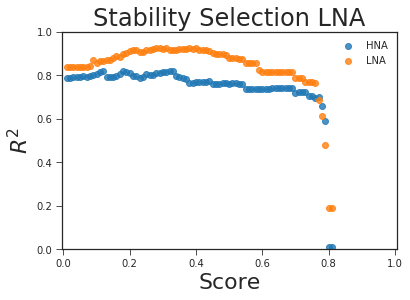

In [34]:
plt.figure()
sns.regplot(x=thr_otu_scores_hna,y=r2_otu_scores_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_scores_lna,y=r2_otu_scores_lna, fit_reg=False, label='LNA')
plt.axis([-0.005,1.005,0,1])
plt.xlabel('Score', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.legend()
plt.title('Stability Selection LNA', size=24)
plt.show()

In [35]:
r2_final = r2_otu_scores_lna.max()
thr_lna = thr_otu_scores_lna[r2_otu_scores_lna.argmax()]
print('R²_cv(lna): ' + str(r2_final) )
print('Threshold score: ' + str(thr_lna))

R²_cv(lna): 0.926078319004
Threshold score: 0.29


In [36]:
otu_scores_lna = otu_scores_lna.assign(abun_abs_mean = data_abs.loc[:,otus].mean())
otu_scores_lna = otu_scores_lna.assign(abun_abs_CV = data_abs.loc[:,otus].std()/data_abs.loc[:,otus].mean())
otu_scores_lna =  otu_scores_lna.assign(abun_rel_mean = data_rel.loc[:,otus].mean())
otu_scores_lna = otu_scores_lna.assign(abun_rel_CV = data_rel.loc[:,otus].std()/data_rel.loc[:,otus].mean())
otu_scores_lna['r_spearman'] = uni_fs_lna.loc[otu_scores.index,'r_spearman']
otu_scores_lna['p_spearman'] = uni_fs_lna.loc[otu_scores.index,'p_spearman']
otu_scores_lna.to_csv('Final/lnascores_otus_abun_5seq10_aitch.csv')


In [37]:
otu_scores_selected_lna = otu_scores_lna[otu_scores_lna.score.values>thr_lna]
selected_otus_lna = otu_scores_selected_lna.index
print('Size list selected OTUs: ' + str(len(selected_otus_lna)))
otu_scores_selected_lna.to_csv('Final/lnascores_otus_tuned_thr_'+str(thr_lna)+'_5seq10_aitch.csv')
display(otu_scores_selected_lna.head(10))

Size list selected OTUs: 107


,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV,r_spearman,p_spearman
Otu000392,0.806667,4160.131757,2.200945,0.000734,1.605259,0.091979,2.357009e-01
Otu000173,0.786667,9202.636543,1.868851,0.001394,1.547572,0.411569,2.984834e-08
Otu000682,0.786667,1400.166800,4.290562,0.000352,1.614426,-0.346569,4.185650e-06
Otu000074,0.776667,13440.587905,0.795363,0.003698,0.846907,-0.575840,3.194077e-16
Otu000060,0.770000,27431.752891,1.430959,0.004103,1.018680,0.595525,1.677884e-17
Otu000113,0.760000,6981.672822,2.487085,0.001010,1.982069,0.176573,2.204540e-02
Otu000221,0.746667,1843.807131,4.783182,0.000568,3.092167,-0.459800,3.613171e-10
Otu000242,0.726667,5151.362021,3.267847,0.000847,2.129433,-0.011414,8.832543e-01
Otu000287,0.716667,6997.545419,4.951683,0.001503,3.720178,-0.544194,2.457739e-14
Otu001067,0.706667,941.789160,3.766670,0.000429,2.335792,-0.565909,1.312202e-15


In [38]:
print('R²_cv of LNA-selected OTUs in function of HNA: ' + str(r2_otu_scores_hna[r2_otu_scores_lna.argmax()]) )

R²_cv of LNA-selected OTUs in function of HNA: 0.810304167489


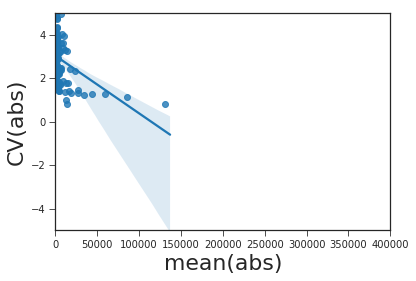

In [39]:
plt.figure()
sns.regplot(x='abun_abs_mean',y='abun_abs_CV', data=otu_scores_selected_lna)
plt.axis([0,400000,-5,5])
plt.xlabel('mean(abs)', size=22)
plt.xticks(size=10)
plt.ylabel('CV(abs)', size=22)
plt.yticks(size=10)
plt.show()

Let's compare the HNA- and LNA-lists, which OTU's are shared (_common_) and which are only part of the HNA- or LNA subset?: 

In [40]:
idx_hna = otu_scores_selected.index.difference(otu_scores_selected_lna.index)
idx_lna = otu_scores_selected_lna.index.difference(otu_scores_selected.index)
idx_common = otu_scores_selected.drop(idx_hna).index
#pd.Series(idx_common).to_csv('commonOTU_HNALNA_5seq10_aitch.csv')
print('Size subset OTUs only related to HNA: ' + str(len(idx_hna)) + '; opposed to total size: ' + str(len(otu_scores_selected)))
print('Size subset OTUs only related to LNA: ' + str(len(idx_lna)) + '; opposed to total size: ' + str(len(otu_scores_selected_lna)))
print('Size subset OTUs related to both: ' + str(len(idx_common)))

display(otu_scores_selected_lna.loc[idx_common,:].head(10))
#data_abs_raw = pd.read_csv('data/Chloroplasts_removed/nochloro_absolute_otu.tsv', sep=' ', index_col=None, header=0)
#data_abs_raw = data_abs_raw.loc[index,:]
#display(data_abs_raw.loc[:,idx_hna].sum(axis=1).values/hna.values)

Size subset OTUs only related to HNA: 11; opposed to total size: 35
Size subset OTUs only related to LNA: 83; opposed to total size: 107
Size subset OTUs related to both: 24


,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV,r_spearman,p_spearman
Otu000173,0.786667,9202.636543,1.868851,0.001394,1.547572,0.411569,2.984834e-08
Otu000682,0.786667,1400.166800,4.290562,0.000352,1.614426,-0.346569,4.185650e-06
Otu000242,0.726667,5151.362021,3.267847,0.000847,2.129433,-0.011414,8.832543e-01
Otu000216,0.370000,8549.311586,3.381402,0.001856,2.870124,-0.304291,6.068591e-05
Otu000535,0.436667,539.500927,3.198874,0.000279,0.838590,-0.510523,1.554171e-12
Otu000088,0.686667,4796.152365,1.417696,0.001929,1.599274,-0.591756,2.995563e-17
Otu000060,0.770000,27431.752891,1.430959,0.004103,1.018680,0.595525,1.677884e-17
Otu000154,0.540000,4420.233668,1.423808,0.001585,2.344583,-0.207794,6.876297e-03
Otu000778,0.330000,1003.428651,3.139226,0.000296,0.830592,-0.229210,2.802446e-03
Otu000313,0.446667,2917.175675,2.192946,0.000532,1.279587,0.146529,5.805246e-02


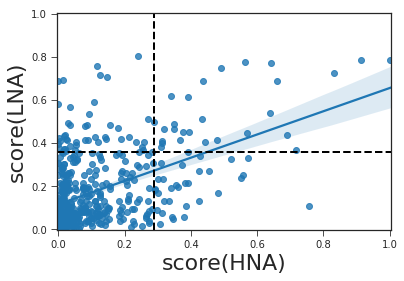

In [41]:
plt.figure()
sns.regplot(x=otu_scores.loc[:,'score'],y=otu_scores_lna.loc[otu_scores.index,'score'])
plt.axis([-0.005,1.005,-0.005,1.005])
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('score(LNA)', size=22)
plt.yticks(size=10)
plt.axhline(y=thr, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=thr_lna, linewidth=2, linestyle='--', color = 'k')
plt.show()

This figure shows 4 area's: 
- (left top corner): OTU's selected solely in function of **LNA**-dynamics, 
- (right top corner): OTU's selected in function of both **HNA**- and **LNA**-dynamics, 
- (left bottom corner): OTU's that are _not_ selected, 
- (right bottom corner): OTU's selected solely in function of **HNA**-dynamics. 

Univariate vs. Stability selection

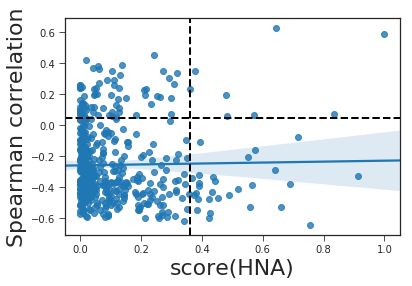

In [42]:
plt.figure()
sns.regplot(x=otu_scores.loc[:,'score'],y=uni_fs.loc[otu_scores.index,'r_spearman'])
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Spearman correlation', size=22)
plt.yticks(size=10)
#plt.yscale('log')
plt.axhline(y=0.05, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=thr, linewidth=2, linestyle='--', color = 'k')
#plt.axis([-0.005,1.005,0.0000000000000000000001, 1])
plt.show()

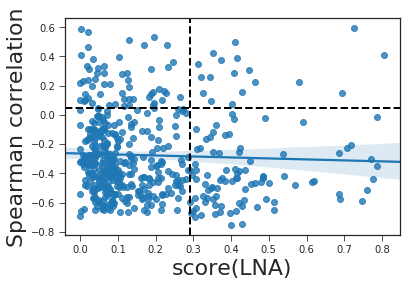

In [43]:
plt.figure()
sns.regplot(x=otu_scores_lna.loc[:,'score'],y=uni_fs_lna.loc[otu_scores.index,'r_spearman'])
plt.xlabel('score(LNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Spearman correlation', size=22)
plt.yticks(size=10)
#plt.yscale('log')
plt.axhline(y=0.05, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=thr_lna, linewidth=2, linestyle='--', color = 'k')
#plt.axis([-0.005,1.005,0.0000000000000000000001, 1])
plt.show()

This analysis shows that the HNA/LNA dynamics cannot solely be attributed to OTU's that are present in the respective cloud; this is also clear from the mutual correlation between HNA- and LNA-counts ( $\rho(\text{HNA,LNA}) = 0.75$ ). 

I see two reasons for this: 
- Some OTU's are simply present in the two clouds; 
- Some HNA-OTU's interact with LNA-OTU's and vice versa. 